# Refi-Ready Borrower Dashboard POC📊

**Interactive Data Visualization for Refinance Opportunities**

This notebook provides a comprehensive dashboard for analyzing refinance-ready borrowers from the AWS data pipeline.

## Features:
- 📈 KPI Metrics (Total borrowers, savings, rate spread, LTV)
- 📊 Marketing category distribution
- 🎯 Rate comparison analysis
- 💰 Top savings opportunities
- 🔥 Engagement metrics analysis
- 📤 Export dashboard as HTML

**Last Updated:** February 22, 2026

## 1. Setup & Installation

First, install the required packages if not already installed.

In [16]:
# Install required packages (run once)
import sys
!{sys.executable} -m pip install boto3 pandas plotly pyathena numpy s3fs -q

print("✓ All packages installed successfully!")

✓ All packages installed successfully!


## 2. Import Libraries

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import boto3
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 3. Configure AWS Athena Connection

Set up connection parameters for AWS Athena.

In [18]:
# AWS Configuration
AWS_REGION = 'us-east-1'
DATABASE_NAME = 'refi_ready_db'
S3_STAGING_DIR = 's3://refi-ready-poc-dev/athena-results/'

# Create Athena connection
conn = connect(
    s3_staging_dir=S3_STAGING_DIR,
    region_name=AWS_REGION,
    cursor_class=PandasCursor
)

print(f"✓ Connected to Athena")
print(f"  Region: {AWS_REGION}")
print(f"  Database: {DATABASE_NAME}")

✓ Connected to Athena
  Region: us-east-1
  Database: refi_ready_db


## 4. Load Data from S3

Load CSV files directly from S3 and join them to create the unified dataset.

In [19]:
# Load data directly from S3 (bypasses Athena)
s3_bucket = 'refi-ready-poc-dev'
borrowers = pd.read_csv(f's3://{s3_bucket}/raw/borrower_information.csv')
loans = pd.read_csv(f's3://{s3_bucket}/raw/loan_information.csv')
market = pd.read_csv(f's3://{s3_bucket}/raw/market_equity.csv')
engagement = pd.read_csv(f's3://{s3_bucket}/raw/borrower_engagement.csv')

print(f"✓ Files loaded from S3")
print(f"  Borrowers: {len(borrowers):,} rows")
print(f"  Loans: {len(loans):,} rows")
print(f"  Market: {len(market):,} rows")
print(f"  Engagement: {len(engagement):,} rows")

# Join the dataframes - borrowers and loans both have borrower_id and property_id
df = borrowers.merge(loans, on='borrower_id', suffixes=('', '_loan'), how='inner')
df = df.merge(market, on='property_id', how='inner')
df = df.merge(engagement, on='borrower_id', how='inner')

# Filter for refinance-eligible borrowers
df = df[
    (df['ltv_ratio'] <= 80) &
    ((df['current_interest_rate'] - df['market_rate_offer']) >= 1.0)
].copy()

print(f"\n✓ Data loaded and joined successfully!")
print(f"  Total refinance-eligible borrowers: {len(df):,}")
print(f"  Columns: {', '.join(df.columns)}")
print(f"\nFirst few rows:")
df.head()

✓ Files loaded from S3
  Borrowers: 51 rows
  Loans: 51 rows
  Market: 51 rows
  Engagement: 51 rows

✓ Data loaded and joined successfully!
  Total refinance-eligible borrowers: 10
  Columns: borrower_id, first_name, last_name, email, phone, property_id, city, state, credit_score, loan_id, property_id_loan, loan_amount, current_interest_rate, origination_year, loan_type, remaining_balance, current_home_value, estimated_equity_amt, ltv_ratio, market_rate_offer, monthly_savings_est, paperless_billing, email_open_last_30d, mobile_app_login_last_30d, sms_opt_in

First few rows:


,borrower_id,first_name,last_name,email,phone,property_id,city,state,credit_score,loan_id,...,remaining_balance,current_home_value,estimated_equity_amt,ltv_ratio,market_rate_offer,monthly_savings_est,paperless_billing,email_open_last_30d,mobile_app_login_last_30d,sms_opt_in
0,1,John,Smith,john.smith@example.com,555-0101,101,Anytown,CA,750,201,...,280000,400000,120000,70,3.2,250,True,True,True,True
1,2,Jane,Doe,jane.doe@example.com,555-0102,102,Anytown,CA,800,202,...,430000,550000,120000,78,2.5,200,True,True,False,False
3,4,Mary,Johnson,mary.johnson@example.com,555-0104,104,Smallville,KS,720,204,...,240000,300000,60000,80,3.5,150,True,True,True,True
4,5,David,Williams,david.williams@example.com,555-0105,105,Metropolis,NY,780,205,...,550000,700000,150000,79,2.8,220,True,False,True,False
8,9,Robert,Wilson,robert.wilson@example.com,555-0109,109,Star City,WA,790,209,...,460000,600000,140000,77,3.0,200,True,True,True,True


## 5. Data Preparation

Add calculated fields for analysis.

In [20]:
# Convert numeric columns to proper types (fix dtype errors)
numeric_columns = ['current_interest_rate', 'market_rate_offer', 'ltv_ratio', 'monthly_savings_est']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert boolean columns to proper types
boolean_columns = ['paperless_billing', 'email_open_last_30d', 'mobile_app_login_last_30d', 'sms_opt_in']
for col in boolean_columns:
    df[col] = df[col].astype(bool)

print("✓ Data types converted successfully!")

# Calculate rate spread
df['rate_spread'] = df['current_interest_rate'] - df['market_rate_offer']

# Create full name
df['full_name'] = df['first_name'] + ' ' + df['last_name']

# Categorize borrowers by marketing priority
def categorize_borrower(rate_spread):
    if rate_spread > 1.25:
        return 'Immediate Action'
    elif rate_spread > 0.75:
        return 'Hot Lead'
    elif rate_spread > 0.50:
        return 'Watchlist'
    else:
        return 'Ineligible'

df['marketing_category'] = df['rate_spread'].apply(categorize_borrower)

# Calculate annual savings
df['annual_savings_est'] = df['monthly_savings_est'] * 12

# Calculate engagement score (0-4)
df['engagement_score'] = (
    df['paperless_billing'].astype(int) +
    df['email_open_last_30d'].astype(int) +
    df['mobile_app_login_last_30d'].astype(int) +
    df['sms_opt_in'].astype(int)
)

print("✓ Data preparation complete!")
print(f"\nData types:")
print(df[numeric_columns + boolean_columns].dtypes)
print(f"\nMarketing Category Distribution:")
print(df['marketing_category'].value_counts())
print(f"\nData shape: {df.shape}")

✓ Data types converted successfully!
✓ Data preparation complete!

Data types:
current_interest_rate        float64
market_rate_offer            float64
ltv_ratio                      int64
monthly_savings_est            int64
paperless_billing               bool
email_open_last_30d             bool
mobile_app_login_last_30d       bool
sms_opt_in                      bool
dtype: object

Marketing Category Distribution:
marketing_category
Immediate Action    6
Hot Lead            4
Name: count, dtype: int64

Data shape: (10, 30)


## 6. Executive KPIs 📊

Key performance indicators at a glance.

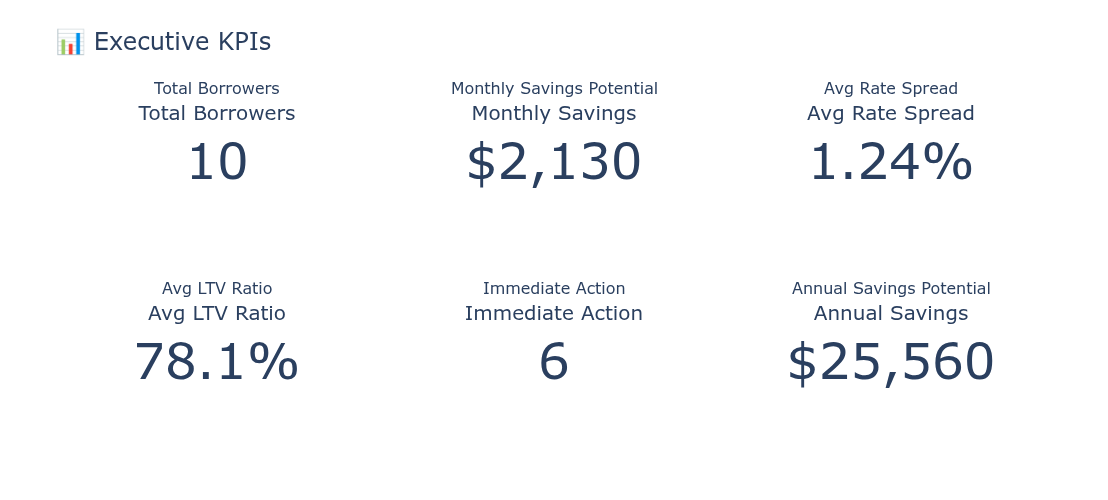


💡 Key Insights:
   • 10 borrowers are refinance-ready
   • $2,130/month potential savings ($25,560/year)
   • Average rate spread: 1.24%
   • 6 borrowers need immediate action


In [21]:
# Calculate KPIs
total_borrowers = len(df)
total_monthly_savings = df['monthly_savings_est'].sum()
total_annual_savings = total_monthly_savings * 12
avg_rate_spread = df['rate_spread'].mean()
avg_ltv = df['ltv_ratio'].mean()
immediate_action_count = len(df[df['marketing_category'] == 'Immediate Action'])

# Create KPI display
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=('Total Borrowers', 'Monthly Savings Potential', 'Avg Rate Spread',
                    'Avg LTV Ratio', 'Immediate Action', 'Annual Savings Potential'),
    specs=[[{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}],
           [{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}]]
)

# Add KPI indicators
fig.add_trace(go.Indicator(
    mode="number",
    value=total_borrowers,
    number={'font': {'size': 50}},
    title={'text': "Total Borrowers", 'font': {'size': 20}}
), row=1, col=1)

fig.add_trace(go.Indicator(
    mode="number",
    value=total_monthly_savings,
    number={'prefix': "$", 'font': {'size': 50}, 'valueformat': ",.0f"},
    title={'text': "Monthly Savings", 'font': {'size': 20}}
), row=1, col=2)

fig.add_trace(go.Indicator(
    mode="number",
    value=avg_rate_spread,
    number={'suffix': "%", 'font': {'size': 50}, 'valueformat': ".2f"},
    title={'text': "Avg Rate Spread", 'font': {'size': 20}}
), row=1, col=3)

fig.add_trace(go.Indicator(
    mode="number",
    value=avg_ltv,
    number={'suffix': "%", 'font': {'size': 50}, 'valueformat': ".1f"},
    title={'text': "Avg LTV Ratio", 'font': {'size': 20}}
), row=2, col=1)

fig.add_trace(go.Indicator(
    mode="number",
    value=immediate_action_count,
    number={'font': {'size': 50}},
    title={'text': "Immediate Action", 'font': {'size': 20}}
), row=2, col=2)

fig.add_trace(go.Indicator(
    mode="number",
    value=total_annual_savings,
    number={'prefix': "$", 'font': {'size': 50}, 'valueformat': ",.0f"},
    title={'text': "Annual Savings", 'font': {'size': 20}}
), row=2, col=3)

fig.update_layout(height=500, title_text="📊 Executive KPIs", title_font_size=24)
fig.show()

print(f"\n💡 Key Insights:")
print(f"   • {total_borrowers:,} borrowers are refinance-ready")
print(f"   • ${total_monthly_savings:,.0f}/month potential savings (${total_annual_savings:,.0f}/year)")
print(f"   • Average rate spread: {avg_rate_spread:.2f}%")
print(f"   • {immediate_action_count} borrowers need immediate action")

## 7. Borrowers by Marketing Category 📊

Distribution of borrowers across urgency tiers.

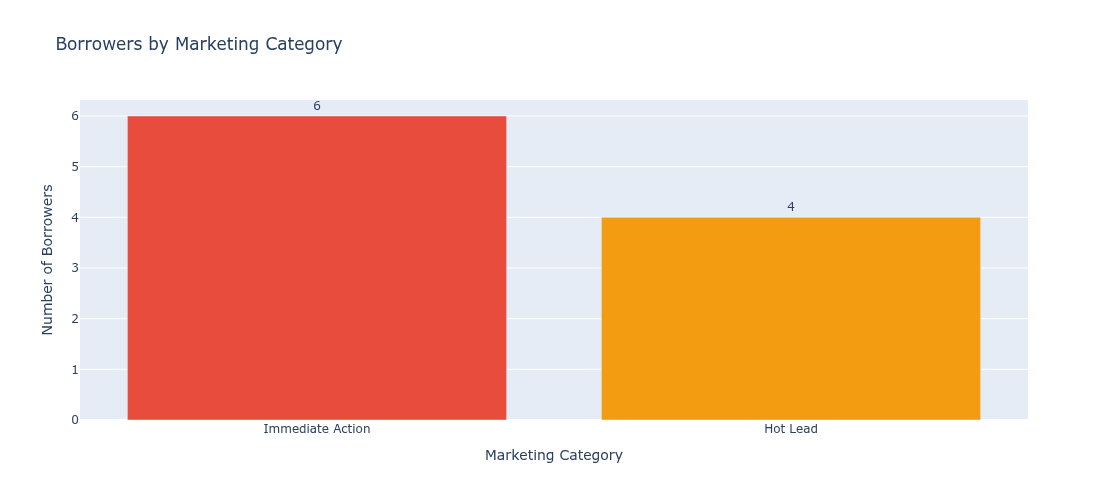


📈 Category Breakdown:
   • Immediate Action: 6 borrowers (60.0%)
   • Hot Lead: 4 borrowers (40.0%)


In [22]:
# Count by category
category_counts = df['marketing_category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Define colors
color_map = {
    'Immediate Action': '#E74C3C',
    'Hot Lead': '#F39C12',
    'Watchlist': '#F1C40F',
    'Ineligible': '#95A5A6'
}

# Create bar chart
fig = px.bar(
    category_counts,
    x='Category',
    y='Count',
    color='Category',
    color_discrete_map=color_map,
    title='Borrowers by Marketing Category',
    text='Count'
)

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    height=500,
    showlegend=False,
    xaxis_title="Marketing Category",
    yaxis_title="Number of Borrowers"
)

fig.show()

print(f"\n📈 Category Breakdown:")
for _, row in category_counts.iterrows():
    pct = (row['Count'] / total_borrowers) * 100
    print(f"   • {row['Category']}: {row['Count']} borrowers ({pct:.1f}%)")

## 8. Rate Comparison Analysis 🎯

Current vs Market Interest Rates - Scatter Plot

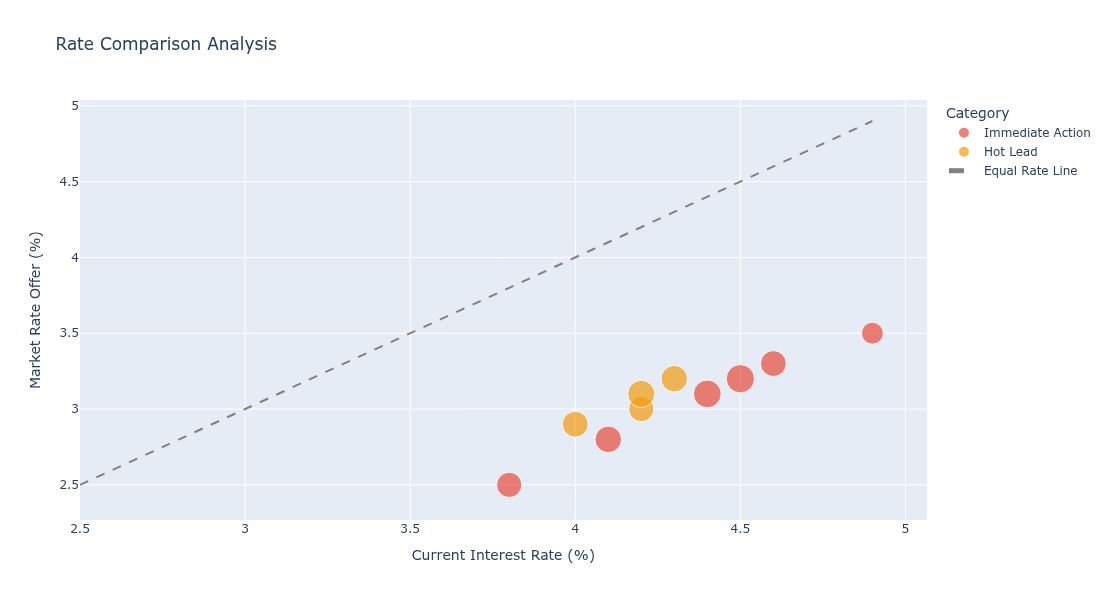


💡 Insight: Points above the diagonal line represent borrowers with
   significant savings opportunities (current rate > market offer)


In [23]:
# Create scatter plot
fig = px.scatter(
    df,
    x='current_interest_rate',
    y='market_rate_offer',
    size='monthly_savings_est',
    color='marketing_category',
    color_discrete_map=color_map,
    hover_data=['full_name', 'rate_spread', 'monthly_savings_est'],
    title='Rate Comparison Analysis',
    labels={
        'current_interest_rate': 'Current Interest Rate (%)',
        'market_rate_offer': 'Market Rate Offer (%)',
        'marketing_category': 'Category'
    }
)

# Add diagonal reference line (where current = market)
min_rate = min(df['current_interest_rate'].min(), df['market_rate_offer'].min())
max_rate = max(df['current_interest_rate'].max(), df['market_rate_offer'].max())
fig.add_trace(go.Scatter(
    x=[min_rate, max_rate],
    y=[min_rate, max_rate],
    mode='lines',
    line=dict(color='gray', dash='dash'),
    name='Equal Rate Line',
    showlegend=True
))

fig.update_layout(height=600)
fig.show()

print("\n💡 Insight: Points above the diagonal line represent borrowers with")
print("   significant savings opportunities (current rate > market offer)")

## 9. Top Savings Opportunities 💰

Top 10 borrowers with highest monthly savings potential.

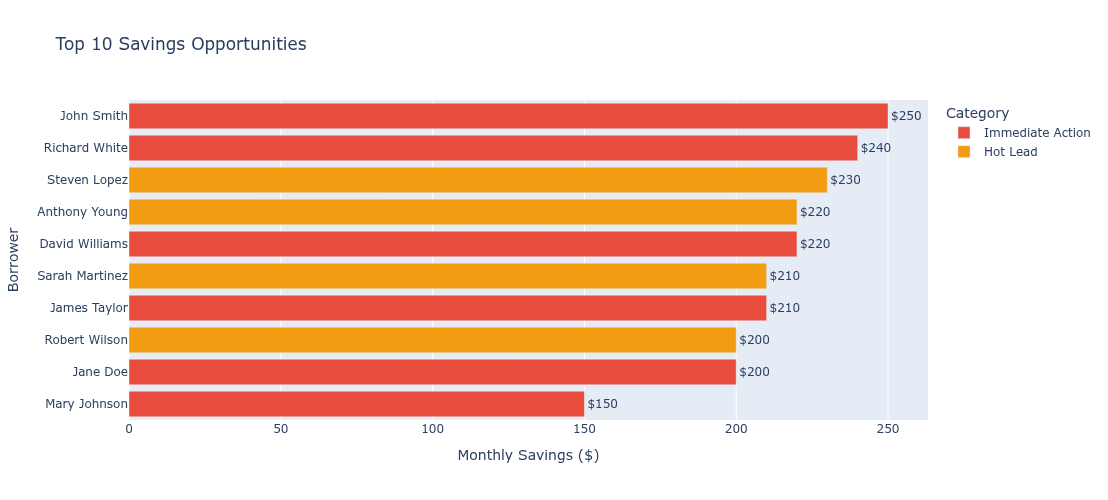


💰 Top Savings Opportunities:
   John Smith: $250/month (Rate spread: 1.30%)
   Richard White: $240/month (Rate spread: 1.30%)
   Steven Lopez: $230/month (Rate spread: 1.10%)
   David Williams: $220/month (Rate spread: 1.30%)
   Anthony Young: $220/month (Rate spread: 1.10%)
   James Taylor: $210/month (Rate spread: 1.30%)
   Sarah Martinez: $210/month (Rate spread: 1.10%)
   Jane Doe: $200/month (Rate spread: 1.30%)
   Robert Wilson: $200/month (Rate spread: 1.20%)
   Mary Johnson: $150/month (Rate spread: 1.40%)


In [24]:
# Get top 10 by savings
top_10 = df.nlargest(10, 'monthly_savings_est')[['full_name', 'monthly_savings_est', 'rate_spread', 'marketing_category']].copy()

# Create horizontal bar chart
fig = px.bar(
    top_10,
    y='full_name',
    x='monthly_savings_est',
    orientation='h',
    color='marketing_category',
    color_discrete_map=color_map,
    title='Top 10 Savings Opportunities',
    labels={
        'monthly_savings_est': 'Monthly Savings ($)',
        'full_name': 'Borrower',
        'marketing_category': 'Category'
    },
    text='monthly_savings_est'
)

fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')
fig.update_layout(height=500, yaxis={'categoryorder': 'total ascending'})
fig.show()

print(f"\n💰 Top Savings Opportunities:")
for idx, row in top_10.iterrows():
    print(f"   {row['full_name']}: ${row['monthly_savings_est']:,.0f}/month (Rate spread: {row['rate_spread']:.2f}%)")

## 10. LTV vs Rate Spread Heatmap 🔥

Distribution heatmap showing the sweet spot for refinancing.

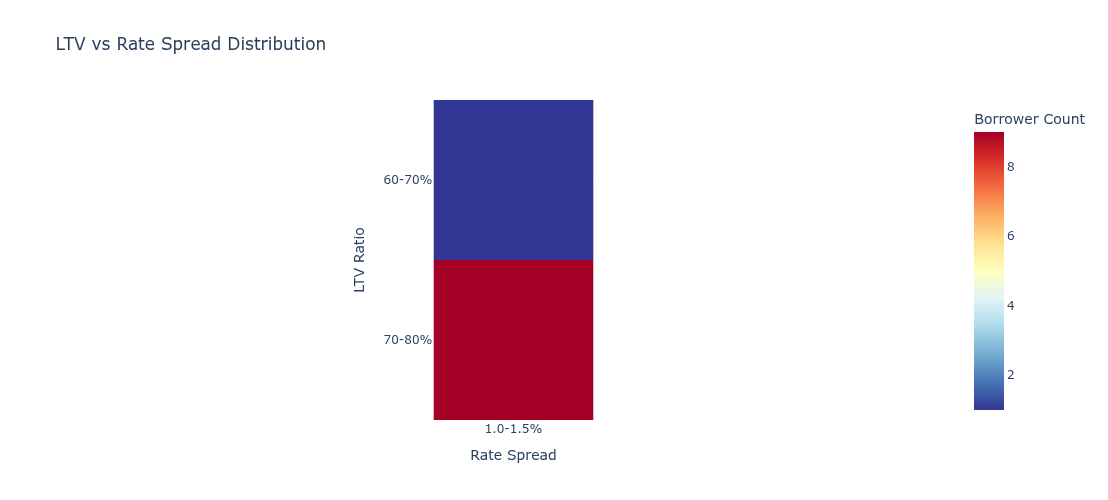


🔥 Heatmap Insight:
   Darker red areas indicate higher concentration of borrowers.
   Sweet spot: Low LTV + High rate spread = Best refinance candidates


In [25]:
# Create bins for LTV and rate spread
df['ltv_bin'] = pd.cut(df['ltv_ratio'], bins=[0, 60, 70, 80, 100], labels=['0-60%', '60-70%', '70-80%', '>80%'])
df['rate_spread_bin'] = pd.cut(df['rate_spread'], bins=[0, 0.5, 1.0, 1.5, 10], labels=['0-0.5%', '0.5-1.0%', '1.0-1.5%', '>1.5%'])

# Create pivot table for heatmap
heatmap_data = df.groupby(['ltv_bin', 'rate_spread_bin']).size().reset_index(name='count')
heatmap_pivot = heatmap_data.pivot(index='ltv_bin', columns='rate_spread_bin', values='count').fillna(0)

# Create heatmap
fig = px.imshow(
    heatmap_pivot,
    labels=dict(x="Rate Spread", y="LTV Ratio", color="Borrower Count"),
    x=heatmap_pivot.columns,
    y=heatmap_pivot.index,
    color_continuous_scale='RdYlBu_r',
    title='LTV vs Rate Spread Distribution'
)

fig.update_layout(height=500)
fig.show()

print("\n🔥 Heatmap Insight:")
print("   Darker red areas indicate higher concentration of borrowers.")
print("   Sweet spot: Low LTV + High rate spread = Best refinance candidates")

## 11. Engagement Metrics Analysis 📱

Digital engagement across different channels.

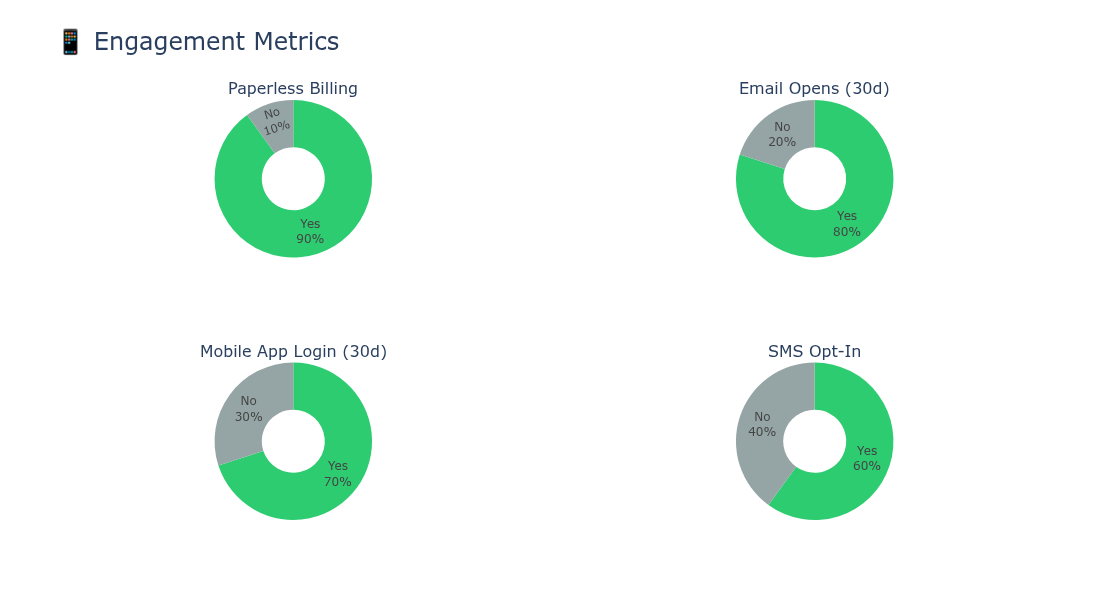


📱 Engagement Summary:
   • Paperless Billing: 90.0% adoption
   • Email Opens (30d): 80.0% adoption
   • Mobile App Login (30d): 70.0% adoption
   • SMS Opt-In: 60.0% adoption


In [26]:
# Calculate engagement percentages
engagement_metrics = {
    'Paperless Billing': df['paperless_billing'].mean() * 100,
    'Email Opens (30d)': df['email_open_last_30d'].mean() * 100,
    'Mobile App Login (30d)': df['mobile_app_login_last_30d'].mean() * 100,
    'SMS Opt-In': df['sms_opt_in'].mean() * 100
}

# Create subplots for pie charts
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=list(engagement_metrics.keys()),
    specs=[[{'type': 'pie'}, {'type': 'pie'}],
           [{'type': 'pie'}, {'type': 'pie'}]]
)

colors = ['#2ECC71', '#95A5A6']  # Green for Yes, Gray for No
row_col_pairs = [(1, 1), (1, 2), (2, 1), (2, 2)]

for idx, (metric, pct) in enumerate(engagement_metrics.items()):
    row, col = row_col_pairs[idx]
    fig.add_trace(go.Pie(
        labels=['Yes', 'No'],
        values=[pct, 100-pct],
        marker=dict(colors=colors),
        hole=0.4,
        textinfo='label+percent',
        textposition='inside'
    ), row=row, col=col)

fig.update_layout(height=600, title_text="📱 Engagement Metrics", title_font_size=24, showlegend=False)
fig.show()

print("\n📱 Engagement Summary:")
for metric, pct in engagement_metrics.items():
    print(f"   • {metric}: {pct:.1f}% adoption")

## 12. Engagement Score Distribution 🎯

How digitally engaged are our refinance-ready borrowers?

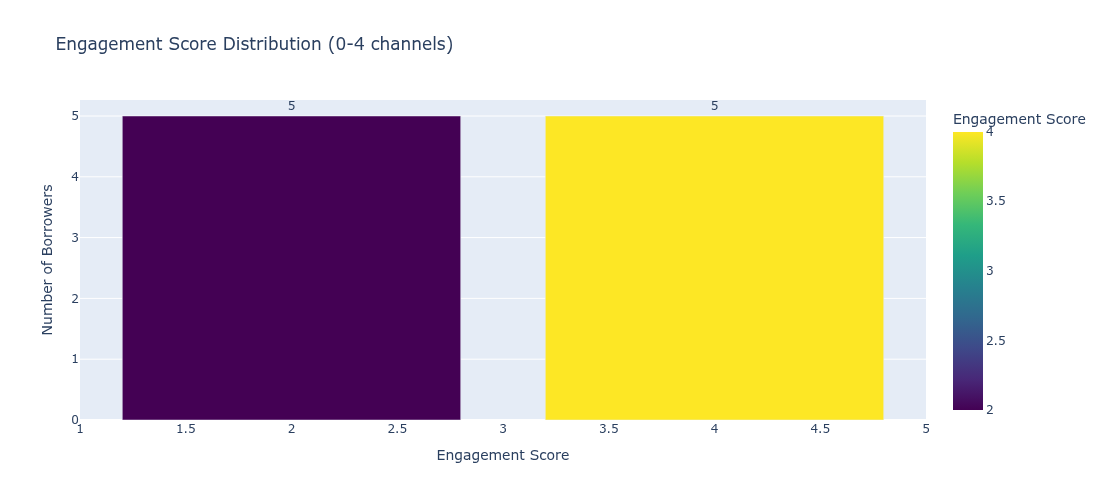


🎯 Average Engagement Score: 3.00 out of 4 channels
   • High engagement (3-4 channels): 5 borrowers
   • Low engagement (0-1 channels): 0 borrowers


In [27]:
# Engagement score distribution
engagement_dist = df['engagement_score'].value_counts().sort_index().reset_index()
engagement_dist.columns = ['Score', 'Count']

fig = px.bar(
    engagement_dist,
    x='Score',
    y='Count',
    title='Engagement Score Distribution (0-4 channels)',
    labels={'Score': 'Engagement Score', 'Count': 'Number of Borrowers'},
    text='Count',
    color='Score',
    color_continuous_scale='Viridis'
)

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(height=500)
fig.show()

avg_engagement = df['engagement_score'].mean()
print(f"\n🎯 Average Engagement Score: {avg_engagement:.2f} out of 4 channels")
print(f"   • High engagement (3-4 channels): {len(df[df['engagement_score'] >= 3])} borrowers")
print(f"   • Low engagement (0-1 channels): {len(df[df['engagement_score'] <= 1])} borrowers")

## 13. Summary Statistics 📋

Comprehensive data summary.

In [28]:
# Display summary statistics
print("=" * 80)
print("REFINANCE POC - SUMMARY STATISTICS")
print("=" * 80)
print(f"\n📊 DATASET OVERVIEW:")
print(f"   Total Borrowers: {len(df):,}")
print(f"   Date Analyzed: February 22, 2026")

print(f"\n💰 FINANCIAL METRICS:")
print(f"   Total Monthly Savings: ${df['monthly_savings_est'].sum():,.0f}")
print(f"   Total Annual Savings: ${df['annual_savings_est'].sum():,.0f}")
print(f"   Average Monthly Savings: ${df['monthly_savings_est'].mean():,.0f}")
print(f"   Max Monthly Savings: ${df['monthly_savings_est'].max():,.0f}")
print(f"   Min Monthly Savings: ${df['monthly_savings_est'].min():,.0f}")

print(f"\n📈 RATE METRICS:")
print(f"   Average Current Rate: {df['current_interest_rate'].mean():.2f}%")
print(f"   Average Market Offer: {df['market_rate_offer'].mean():.2f}%")
print(f"   Average Rate Spread: {df['rate_spread'].mean():.2f}%")
print(f"   Max Rate Spread: {df['rate_spread'].max():.2f}%")

print(f"\n🏠 LTV METRICS:")
print(f"   Average LTV Ratio: {df['ltv_ratio'].mean():.1f}%")
print(f"   Max LTV Ratio: {df['ltv_ratio'].max():.1f}%")
print(f"   Min LTV Ratio: {df['ltv_ratio'].min():.1f}%")

print(f"\n📱 ENGAGEMENT METRICS:")
print(f"   Average Engagement Score: {df['engagement_score'].mean():.2f}/4")
print(f"   Paperless Adoption: {df['paperless_billing'].mean()*100:.1f}%")
print(f"   Email Active: {df['email_open_last_30d'].mean()*100:.1f}%")
print(f"   Mobile App Active: {df['mobile_app_login_last_30d'].mean()*100:.1f}%")
print(f"   SMS Opt-In: {df['sms_opt_in'].mean()*100:.1f}%")

print(f"\n🎯 MARKETING CATEGORIES:")
for category in ['Immediate Action', 'Hot Lead', 'Watchlist', 'Ineligible']:
    count = len(df[df['marketing_category'] == category])
    pct = (count / len(df)) * 100
    print(f"   {category}: {count} ({pct:.1f}%)")

print("\n" + "=" * 80)

REFINANCE POC - SUMMARY STATISTICS

📊 DATASET OVERVIEW:
   Total Borrowers: 10
   Date Analyzed: February 22, 2026

💰 FINANCIAL METRICS:
   Total Monthly Savings: $2,130
   Total Annual Savings: $25,560
   Average Monthly Savings: $213
   Max Monthly Savings: $250
   Min Monthly Savings: $150

📈 RATE METRICS:
   Average Current Rate: 4.30%
   Average Market Offer: 3.06%
   Average Rate Spread: 1.24%
   Max Rate Spread: 1.40%

🏠 LTV METRICS:
   Average LTV Ratio: 78.1%
   Max LTV Ratio: 80.0%
   Min LTV Ratio: 70.0%

📱 ENGAGEMENT METRICS:
   Average Engagement Score: 3.00/4
   Paperless Adoption: 90.0%
   Email Active: 80.0%
   Mobile App Active: 70.0%
   SMS Opt-In: 60.0%

🎯 MARKETING CATEGORIES:
   Immediate Action: 6 (60.0%)
   Hot Lead: 4 (40.0%)
   Watchlist: 0 (0.0%)
   Ineligible: 0 (0.0%)



## 14. Export Dashboard 📤

Save all visualizations as a standalone HTML file.

In [29]:
# Create combined dashboard HTML
from datetime import datetime

html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Refi-Ready Borrower Dashboard</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; background: #f5f5f5; }}
        h1 {{ color: #2C3E50; text-align: center; }}
        .summary {{ background: white; padding: 20px; border-radius: 10px; margin: 20px 0; }}
        .metric {{ display: inline-block; margin: 10px 20px; }}
        .metric-value {{ font-size: 32px; font-weight: bold; color: #3498DB; }}
        .metric-label {{ font-size: 14px; color: #7F8C8D; }}
    </style>
</head>
<body>
    <h1>📊 Refi-Ready Borrower Dashboard</h1>
    <div class="summary">
        <div class="metric">
            <div class="metric-value">{len(df):,}</div>
            <div class="metric-label">Total Borrowers</div>
        </div>
        <div class="metric">
            <div class="metric-value">${df['monthly_savings_est'].sum():,.0f}</div>
            <div class="metric-label">Monthly Savings</div>
        </div>
        <div class="metric">
            <div class="metric-value">{df['rate_spread'].mean():.2f}%</div>
            <div class="metric-label">Avg Rate Spread</div>
        </div>
        <div class="metric">
            <div class="metric-value">{df['ltv_ratio'].mean():.1f}%</div>
            <div class="metric-label">Avg LTV</div>
        </div>
    </div>
    <p style="text-align: center; color: #7F8C8D;">Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
</body>
</html>
"""

# Save the HTML file
output_file = 'refi_dashboard_export.html'
with open(output_file, 'w') as f:
    f.write(html_content)

print(f"✓ Dashboard exported to: {output_file}")
print(f"\nTo view the dashboard:")
print(f"   1. Open the file in your browser")
print(f"   2. Or run: python -m http.server 8000")
print(f"   3. Then visit: http://localhost:8000/{output_file}")

✓ Dashboard exported to: refi_dashboard_export.html

To view the dashboard:
   1. Open the file in your browser
   2. Or run: python -m http.server 8000
   3. Then visit: http://localhost:8000/refi_dashboard_export.html


## 15. Data Export 💾

Export the processed data for further analysis or integration.

In [30]:
# Export to CSV
csv_output = 'refi_borrowers_analyzed.csv'
df.to_csv(csv_output, index=False)
print(f"✓ Data exported to: {csv_output}")

# Export summary by category
summary_by_category = df.groupby('marketing_category').agg({
    'borrower_id': 'count',
    'monthly_savings_est': ['sum', 'mean'],
    'rate_spread': 'mean',
    'ltv_ratio': 'mean',
    'engagement_score': 'mean'
}).round(2)

summary_csv = 'refi_summary_by_category.csv'
summary_by_category.to_csv(summary_csv)
print(f"✓ Summary exported to: {summary_csv}")

# Export top opportunities
top_opportunities = df.nlargest(20, 'monthly_savings_est')[
    ['full_name', 'monthly_savings_est', 'rate_spread', 'ltv_ratio', 'marketing_category', 'engagement_score']
]
top_csv = 'refi_top_opportunities.csv'
top_opportunities.to_csv(top_csv, index=False)
print(f"✓ Top opportunities exported to: {top_csv}")

print(f"\n📁 Files created:")
print(f"   • {csv_output} - Full dataset with calculated fields")
print(f"   • {summary_csv} - Summary statistics by category")
print(f"   • {top_csv} - Top 20 savings opportunities")
print(f"   • {output_file} - Interactive HTML dashboard")

✓ Data exported to: refi_borrowers_analyzed.csv
✓ Summary exported to: refi_summary_by_category.csv
✓ Top opportunities exported to: refi_top_opportunities.csv

📁 Files created:
   • refi_borrowers_analyzed.csv - Full dataset with calculated fields
   • refi_summary_by_category.csv - Summary statistics by category
   • refi_top_opportunities.csv - Top 20 savings opportunities
   • refi_dashboard_export.html - Interactive HTML dashboard


---

## 🎯 Next Steps

### For Marketing Teams:
1. Review "Immediate Action" borrowers for urgent campaigns
2. Use engagement metrics to choose optimal communication channels
3. Export filtered lists for CRM/email platform integration

### For Analytics Teams:
1. Refine marketing category thresholds based on conversion data
2. Add historical trend analysis
3. Integrate with additional data sources (credit scores, demographics)

### For Executives:
1. Review KPIs for ROI projections
2. Allocate budget based on total savings potential
3. Track conversion rates by category

---

**Dashboard Ready! ✨**

All visualizations are interactive - hover for details, zoom, pan, and click legends to filter.

For questions or improvements, contact the Data Analytics team.